## Import Python libary

In [1]:
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import sounddevice as sd
import time
import os
import re
import math
import matplotlib.pyplot as plt
import speech_recognition as sr
from tensorflow import keras
from pydub import AudioSegment
from word2number import w2n
# import webrtcvad # 這個有可能需要額外下載 Microsoft C++ Build Tools 這個是用在VAD那個函數。
# import noisereduce as nr  # 需要額外的pip install torch
# import audiosegment

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Global variables

In [2]:
Speakers = ['Allen', 'Benjamin', 'Han', 'Hua', 'Jackson', 'Noah', 'Olivia', 'Patrick', 'Rain', 'Xin']
NumOfSpeakers = 10
NumOfDataOfSpeaker = [] # 儲存每個speaker的音檔數量：[72, 92, 72, 72, 98, 106, 97, 72, 72, 72]
AudioFiles = []  # 包含所有的音檔：[[(y, sr), (y, sr)......], [], []......]
CNN_DataFrame = pd.DataFrame()  # 包含所有音檔的CNN DataFrame
CNN_training_y = pd.DataFrame()
CNN_training_X = pd.DataFrame()            
CNN_validation_y = pd.DataFrame()
CNN_validation_X = pd.DataFrame()
test_data = [] # 儲存錄音後將聲音轉成音訊的numpy array
recognizer = sr.Recognizer() # 語音轉文字

## Read files
Read files from dataset and store their y and sr into AudioFiles

In [3]:
def ReadFile(AudioFiles, NumOfDataOfSpeaker):
    base_path = 'dataset'
    for name in os.listdir(base_path):
        name_path = os.path.join(base_path, name)     # name_path = dataset/name
        tmp = []
        cnt = 0
        for file_name in os.listdir(name_path):
            if file_name.endswith('.flac'):
                file_path = os.path.join(name_path, file_name)  # file_path = dataset/name/file_name

                # 判斷音檔長度，大於10秒才保留
                duration = librosa.get_duration(path=file_path)
                if duration < 10: continue
                    
                # y, sr = load_and_normalize_audio(file_path)
                y, sr = librosa.load(file_path, sr=None)
                y = y[:int(sr * 10)] 
                tmp.append((y, sr))
                cnt += 1
                    
        NumOfDataOfSpeaker.append(cnt)
        AudioFiles.append(tmp)

ReadFile(AudioFiles, NumOfDataOfSpeaker)

## VAD and Noise reduction

##### Implement VAD algorithm

In [4]:
# # 這個可以知道音檔資料，因為vad.is_speech這個函數對音檔格式很要求，
# # Sample Rate要是8k、16k、32k
# # Channels要是單聲道
# # Sample Width也規定要是16位元
# def get_audio_info(audio_file):
#     audio_data, sample_rate = sf.read(audio_file)
#     # 獲取音訊資訊
#     sample_width = audio_data.dtype.itemsize * 8  # 計算取樣寬度（以位元表示）
#     n_channels = audio_data.shape[1] if len(audio_data.shape) > 1 else 1  # 計算通道數
#     n_frames = audio_data.shape[0]  # 計算幀數
#     # 輸出音訊資訊
#     # print(f"原音訊資訊：")
#     print(f"取樣率(Sample Rate): {sample_rate}")
#     print(f"取樣寬度(Sample Width): {sample_width}")
#     print(f"通道數(Channels): {n_channels}")
#     print(f"幀數(Frames): {n_frames}")

# # 如果Sample Rate跟Channels不對的話可以用這個轉換一下，但需要一個新的檔案來存這個修改過後的音檔
# def convert_audio(input_file, output_file, target_sample_rate=16000):
#     # 讀取音訊檔案
#     audio_data, sample_rate = sf.read(input_file)

#     # 如果音訊是雙聲道，將其轉換為單聲道
#     if audio_data.ndim > 1:
#         audio_data = audio_data.mean(axis=1)

#     # 計算重取樣後的長度
#     num_samples = round(len(audio_data) * float(target_sample_rate) / sample_rate)

#     # 執行重取樣
#     resampled_audio = resample(audio_data, num_samples)

#     # 寫入重取樣後的音訊檔案
#     sf.write(output_file, resampled_audio, target_sample_rate)


# # 這個主要的功能是吃一段音檔，然後他可以告訴你這段音檔是不是刻意錄音的
# # 如果是那種背景音她會當作是沒有錄音，但背景音也不能太大聲，比如說像是電風扇的聲音她會視作不是語音這樣
# def VAD(audio_file):

#     audio_data, sample_rate = sf.read(audio_file)

#     # 初始化 VAD
#     vad = webrtcvad.Vad()
#     vad.set_mode(3) 

#     # 轉換成 16 位元 PCM 格式
#     audio_data_pcm = (audio_data * (2 ** 15)).astype('int16')

#     # 切割為 10 毫秒片段
#     frame_duration = 10  # 毫秒
#     frame_length = int(sample_rate * (frame_duration / 1000))

#     offset = 0
#     speech_results = []
#     while offset + frame_length < len(audio_data_pcm):
#         frame = audio_data_pcm[offset:offset + frame_length]
#         is_speech = vad.is_speech(frame.tobytes(), sample_rate)
#         speech_results.append(is_speech)
#         offset += frame_length

#     # if any(speech_results):
#     #     print("此音訊檔案包含錄音")
#     # else:
#     #     print("此音訊檔案不包含錄音")
    
#     for i in range(len(speech_results)):
#         speech_results[i] = 1 if speech_results[i] else 0

#     print(f"1是有錄音的片段0沒有: {speech_results}") 

# audio_file = "dataset/Abigail/150-126107-0002.flac"
# get_audio_info(audio_file)
# VAD(audio_file)

In [5]:
# #對我們所有的 data_set 做 VAD，可以用，但會跑一陣子
# def VAD_for_folder(base_path):
#     all_results = []  # 用於存儲所有音檔的結果

#     for person in os.listdir(base_path):
#         person_path = os.path.join(base_path, person)
#         if os.path.isdir(person_path):  # 確保是資料夾
#             person_results = []  # 用於存儲這個人的音檔結果
#             for file_name in os.listdir(person_path):
#                 if file_name.endswith('.flac'):
#                     audio_file = os.path.join(person_path, file_name)
#                     audio_data, sample_rate = sf.read(audio_file)

#                     # 初始化 VAD
#                     vad = webrtcvad.Vad()
#                     vad.set_mode(3) 

#                     # 轉換成 16 位元 PCM 格式
#                     audio_data_pcm = (audio_data * (2 ** 15)).astype('int16')

#                     # 切割為 10 毫秒片段
#                     frame_duration = 10  # 毫秒
#                     frame_length = int(sample_rate * (frame_duration / 1000))

#                     offset = 0
#                     speech_results = []
#                     while offset + frame_length < len(audio_data_pcm):
#                         frame = audio_data_pcm[offset:offset + frame_length]
#                         is_speech = vad.is_speech(frame.tobytes(), sample_rate)
#                         speech_results.append(is_speech)
#                         offset += frame_length

#                     speech_results_numeric = [1 if result else 0 for result in speech_results]
#                     person_results.append(speech_results_numeric)
            
#             all_results.append(person_results)  # 將這個人的結果添加到所有結果中

#     return all_results

# # 資料夾路徑
# A_base_path = 'dataset'

# # 呼叫 VAD_for_folder 函式處理整個資料夾
# results = VAD_for_folder(A_base_path)

# # 印出所有音檔的結果
# for person_results in results:
#     for audio_results in person_results:
#         print(audio_results)  # 每個音檔的結果

##### Implement Noise reduction

In [6]:
# def NoiseReduction(y, sr, audio_channels):
#     # 進行降噪處理
#     reduced_noise = nr.reduce_noise(y, sr)

#     reduced_audio = audiosegment(
#         reduced_noise.tobytes(),
#         frame_rate=sr,
#         sample_width=5,
#         channels=audio_channels
#     )

#     # 將降噪後的音檔保存為新檔案
#     denoised_file_path = "denoised_audio.wav"
#     sf.write(denoised_file_path, reduced_audio, sr)

#     print(f"Denoised audio file saved at: {denoised_file_path}")
#     return reduced_noise

## Extract Features

##### Melspectrograms

In [4]:
def Melspectrogram(y, sr):
    # 計算梅爾頻譜圖
    melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    # 將梅爾頻譜圖轉換為分貝表示
    log_melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)
    return log_melspectrogram

##### MFCC coefficient

In [5]:
def MFCC(y, sr):
    # Compute MFCC features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Compute Delta and Delta-Delta features
    delta_mfcc = librosa.feature.delta(mfccs)
    delta_delta_mfcc = librosa.feature.delta(mfccs, order=2)

    # Stack the original MFCC features, Delta, and Delta-Delta features along the feature axis
    combined_features = np.concatenate([mfccs, delta_mfcc, delta_delta_mfcc], axis=0)

    return combined_features

##### Zero Crossing Rate

In [6]:
def Zero_crossing_rate(y):
    zero_crossings_rate = librosa.feature.zero_crossing_rate(y).reshape(-1)
    return zero_crossings_rate

##### F0

In [7]:
def F0(y):
    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    return f0

##### HighFrequencyEnergy

In [8]:
def high_frequency_energy(y, sr, high_freq_range=(2000, 8000)):
    # 計算STFT
    D = librosa.stft(y)

    # 計算頻譜
    spectrum, _ = librosa.magphase(D)

    # 定義高頻區域的索引範圍
    high_freq_indices = librosa.core.fft_frequencies(sr=sr)
    high_freq_indices = np.where(np.logical_and(high_freq_indices >= high_freq_range[0], high_freq_indices <= high_freq_range[1]))[0]

    # 提取高頻區域的能量
    high_freq_energy = np.sum(spectrum[high_freq_indices, :], axis=0)

    # # 顯示頻譜圖
    # plt.figure(figsize=(10, 6))
    # librosa.display.specshow(librosa.amplitude_to_db(spectrum, ref=np.max), y_axis='log', x_axis='time')
    # plt.colorbar(format='%+2.0f dB')
    # plt.title('Spectrogram')
    # plt.show()

    return high_freq_energy

## Build DataFrame

##### CNN DataFrame

In [9]:
def BuildCNNDataFrame():
    DataFrame = pd.DataFrame(columns=['Melspectrogram', 'Speaker']) 
    for i in range(NumOfSpeakers):
        for audio_file in AudioFiles[i]:
            data = pd.DataFrame({
                'Melspectrogram': [Melspectrogram(audio_file[0], audio_file[1])], 
                'MFCC': [MFCC(audio_file[0], audio_file[1])],
                'ZCR': [Zero_crossing_rate(audio_file[0])],
                'F0': [F0(audio_file[0])],
                'HFE': [high_frequency_energy(audio_file[0], audio_file[1])],
                'Speaker': i
            })
            DataFrame = pd.concat([DataFrame, data], ignore_index=True)
        print(end='\n')
    return DataFrame

CNN_DataFrame = BuildCNNDataFrame()
CNN_DataFrame = CNN_DataFrame.sample(frac=1).reset_index(drop=True)

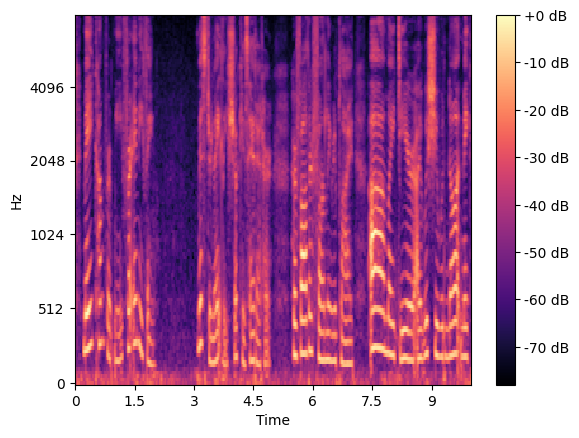

In [11]:
# 顯示梅爾頻譜圖
librosa.display.specshow(CNN_DataFrame.at[0, 'Melspectrogram'], sr=AudioFiles[0][0][1], x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.show()

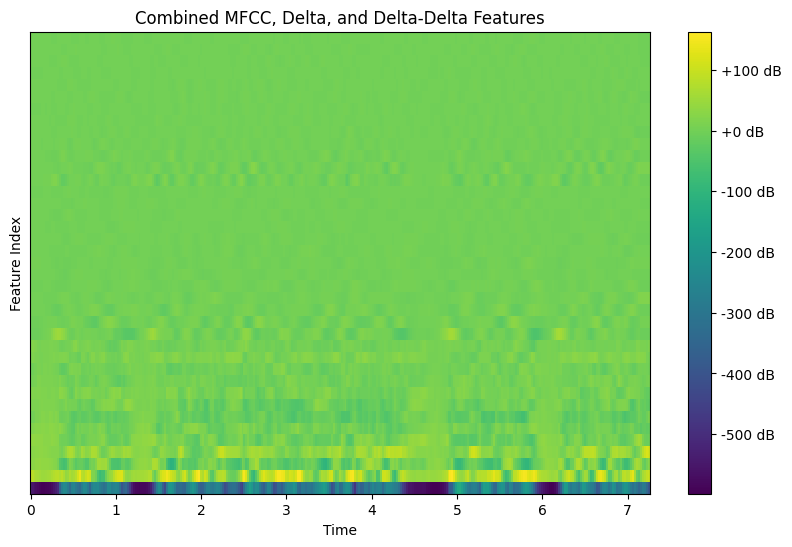

In [32]:
plt.figure(figsize=(10, 6))
librosa.display.specshow(CNN_DataFrame['MFCC'][0], x_axis='time', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Combined MFCC, Delta, and Delta-Delta Features')
plt.xlabel('Time')
plt.ylabel('Feature Index')
plt.show()

## Split data

In [10]:
def Split_training_and_validation(y, X):
    training_y = pd.DataFrame() 
    training_X = pd.DataFrame()
    validation_y = pd.DataFrame()
    validation_X = pd.DataFrame()

    split_size = math.floor(X.shape[0] * 0.8)
    training_y = y.iloc[:split_size, :]
    validation_y = y.iloc[split_size:, :]
    training_X = X.iloc[:split_size, :]
    validation_X = X.iloc[split_size:, :]
    return training_y, training_X, validation_y, validation_X
        
def SplitCNNData(DataFrame):
    y = DataFrame.drop('Melspectrogram', axis=1)
    X = DataFrame.drop('Speaker', axis=1)
    return Split_training_and_validation(y, X)

CNN_training_y, CNN_training_X, CNN_validation_y, CNN_validation_X = SplitCNNData(CNN_DataFrame)

## Build Two models 

### CNN model

In [11]:
class CNN:
    def __init__(self, training_X, validation_X, training_y, validation_y):
        # 提取梅爾頻譜圖列
        self.X_train_mel = np.stack(training_X['Melspectrogram'])
        self.X_val_mel = np.stack(validation_X['Melspectrogram'])
        # 提取MFCC列
        self.X_train_mfcc = np.stack(training_X['MFCC'])
        self.X_val_mfcc = np.stack(validation_X['MFCC'])
        # 提取 zero-crossing rate 列
        self.X_train_zcr = np.array([zcr for zcr in training_X['ZCR']])
        self.X_val_zcr = np.array([zcr for zcr in validation_X['ZCR']])
        # 提取基頻列
        self.X_train_f0 = np.array([f0 for f0 in training_X['F0']])
        self.X_val_f0 = np.array([f0 for f0 in validation_X['F0']])
        #提取高頻能量列
        self.X_train_hfe = np.array([hfe for hfe in training_X['HFE']])
        self.X_val_hfe = np.array([hfe for hfe in validation_X['HFE']])
        # 提取目標列（Speaker）
        self.y_train_speaker = np.array(training_y['Speaker']).astype('int32')
        self.y_val_speaker = np.array(validation_y['Speaker']).astype('int32')

    def define_and_compile_model(self):
        # 定義mel模型
        mel_input = keras.layers.Input(shape=(128, 313))
        x = keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(mel_input)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.MaxPooling1D(pool_size=2)(x)
        x = keras.layers.Flatten()(x)
        mel_output = keras.layers.Dense(128, activation='relu')(x)

        # 定義MFCC的模型
        mfcc_input = keras.layers.Input(shape=(39, 313))  # 設置為MFCC的形狀
        mfcc_output = keras.layers.Dense(64, activation='relu')(mfcc_input)
        mfcc_output = keras.layers.Dense(64, activation='relu')(mfcc_output)
        mfcc_output = keras.layers.Flatten()(mfcc_output)  # Flatten the mfcc_output

        # 定義 zero-crossing rate 的模型
        zcr_input = keras.layers.Input(shape=(313,))  # Adjust the shape to match the size of your flattened ZCR feature
        zcr_output = keras.layers.Dense(64, activation='relu')(zcr_input)
        zcr_output = keras.layers.Dense(64, activation='relu')(zcr_output)  

        # 定義 f0 的模型
        f0_input = keras.layers.Input(shape=(313,))
        f0_output = keras.layers.Dense(64, activation='relu')(f0_input)  
        f0_output = keras.layers.Dense(64, activation='relu')(f0_output)  

        # 定義 HFE 的模型
        hfe_input = keras.layers.Input(shape=(313,))
        hfe_output = keras.layers.Dense(64, activation='relu')(hfe_input) 
        hfe_output = keras.layers.Dense(64, activation='relu')(hfe_output) 

        # 將五個模型的輸出串聯起來
        merged_output = keras.layers.Concatenate()([mel_output, mfcc_output, zcr_output, f0_output, hfe_output])
        final_output = keras.layers.Dense(NumOfSpeakers, activation='softmax')(merged_output)

        # 創建新的模型
        self.model = keras.models.Model(inputs=[mel_input, mfcc_input, zcr_input, f0_input, hfe_input], outputs=final_output)

        # 編譯模型
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    def train_model(self):
        # 訓練模型
        history = self.model.fit(
            [self.X_train_mel, self.X_train_mfcc, self.X_train_zcr, self.X_train_f0, self.X_train_hfe],
            self.y_train_speaker,
            epochs=500,
            batch_size=32,
            validation_data=(
                [self.X_val_mel, self.X_val_mfcc, self.X_val_zcr, self.X_val_f0, self.X_val_hfe],
                self.y_val_speaker
            )
        )

        # 獲取 history 對象
        training_loss = history.history['loss']
        training_accuracy = history.history['accuracy']
        validation_loss = history.history['val_loss']
        validation_accuracy = history.history['val_accuracy']

        # 印出最後一個 epoch 的訓練損失、訓練準確率、驗證損失和驗證準確率
        print(f"Final Training Loss: {training_loss[-1]}, Training Accuracy: {training_accuracy[-1]}")
        print(f"Final Validation Loss: {validation_loss[-1]}, Validation Accuracy: {validation_accuracy[-1]}")

    def prediction(self, mel, mfcc, zcr, f0, hfe, top_n=5):
        # 將 mel、mfcc、zcr 和 chroma 轉換為模型期望的形狀
        mel = np.expand_dims(mel, axis=0)
        mfcc = np.expand_dims(mfcc, axis=0)
        zcr = np.expand_dims(zcr, axis=0)
        f0 = np.expand_dims(f0, axis=0)
        hfe = np.expand_dims(hfe, axis=0)

        # 使用模型進行預測
        predictions = self.model.predict([mel, mfcc, zcr, f0, hfe], verbose=0)

        # 獲取前 top_n 個預測的說話者 id
        top_n_speakers_indices = np.argsort(predictions[0])[-top_n:][::-1]
        top_n_speakers_probabilities = predictions[0][top_n_speakers_indices]

        return (top_n_speakers_indices, top_n_speakers_probabilities)
    

In [12]:
CNN_model = CNN(CNN_training_X, CNN_validation_X, CNN_training_y, CNN_validation_y)
CNN_model.define_and_compile_model()
CNN_model.train_model()




Epoch 1/500


23/23 [==============================] - 2s 17ms/step - loss: 49.4812 - accuracy: 0.2459 - val_loss: 163.5473 - val_accuracy: 0.1038
Epoch 2/500
23/23 [==============================] - 0s 9ms/step - loss: 7.2695 - accuracy: 0.6708 - val_loss: 118.8721 - val_accuracy: 0.1639
Epoch 3/500
23/23 [==============================] - 0s 8ms/step - loss: 0.9567 - accuracy: 0.9044 - val_loss: 82.3041 - val_accuracy: 0.1749
Epoch 4/500
23/23 [==============================] - 0s 8ms/step - loss: 0.9781 - accuracy: 0.9126 - val_loss: 42.3519 - val_accuracy: 0.2678
Epoch 5/500
23/23 [==============================] - 0s 8ms/step - loss: 0.1457 - accuracy: 0.9754 - val_loss: 68.8788 - val_accuracy: 0.2077
Epoch 6/500
23/23 [==============================] - 0s 8ms/step - loss: 0.0758 - accuracy: 0.9891 - val_loss: 37.7390 - val_accuracy: 0.3169
Epoch 7/500
23/23 [==============================] - 0s 8ms/step - loss: 0.0223 - accuracy: 0.9918 - val_loss: 24.4496 - val_accuracy: 0.39

## Test our model

#### Recording

In [13]:
def Recording():
    # 錄音參數設定
    duration = 10  # 錄音秒數
    sample_rate = 16000  # 取樣率(samples per second)

    print(f"If you want to sent money to someone,")
    print(f"please say the sentence \"Hey Voice Payment, please transfer (How much: ex.$3000) to (who)\"")
    print(f"Please say something...")
        
    # 使用'sd.rec'錄音，將錄音資料存入'audio_data'
    audio_data = sd.rec(int(sample_rate * duration), samplerate=sample_rate, channels=2, dtype='int16')
    sd.wait()  # 等待錄音完成 

    # 將錄音資料存檔
    audio_file_path = "test_audio.flac"
    sf.write(audio_file_path, audio_data, sample_rate)

#### Input data preprocessing

In [21]:
def Input_data_preprocessing_CNN():
    input_y, input_sr = librosa.load("test_audio.flac", sr=None)
    input_y = input_y[:int(16000 * 10)]
    input_mel = Melspectrogram(input_y, input_sr)
    input_MFCC = MFCC(input_y, input_sr)
    input_ZCR = Zero_crossing_rate(input_y)
    input_f0 = F0(input_y)
    input_hfe = high_frequency_energy(input_y, input_sr)
    return input_mel, input_MFCC, input_ZCR, input_f0, input_hfe

#### Show what the speaker just said

In [15]:
def text_to_number(sentence):
    words = sentence.split()
    result = []

    for word in words:
        try:
            # 嘗試將文字轉換為數字
            number = w2n.word_to_num(word)
            result.append("$" + str(number))
        except ValueError:
            # 如果轉換失敗，保留原樣
            result.append(word)
    return ' '.join(result)

def transcribe_audio(file_path):
    with sr.AudioFile(file_path) as source:
        audio = recognizer.record(source)
    text = recognizer.recognize_google(audio)  # google的speech to text要連網才能用
    text = text_to_number(text)
    return text

In [23]:
Recording()
input_mel, input_MFCC, input_ZCR, input_f0, input_hfe = Input_data_preprocessing_CNN()
predicted_speaker_ids, predicted_speaker_probability = CNN_model.prediction(input_mel, input_MFCC, input_ZCR, input_f0, input_hfe)

# print(f"Hello {Speakers[CNN_predicted_speaker_id]}!")
# print(f"Hello {Speakers[RNN_predicted_speaker_id]}!")
# print("Your request is accepted!")
# request = transcribe_audio("test_audio.flac")
# print("Transfer...")
# index_of_transfer = request.find("transfer")
# if index_of_transfer != -1: tmp = request[index_of_transfer:]
# else: print("The word 'transfer' was not found in the string.")
# print(f"{Speakers[CNN_predicted_speaker_id]}: Successfully " + tmp)

print("Top 5 Predicted Speakers for CNN:")
for i in range(5):
    print(f"Rank {i}: {Speakers[predicted_speaker_ids[i]]}. The probability is {predicted_speaker_probability[i]}")

If you want to sent money to someone,
please say the sentence "Hey Voice Payment, please transfer (How much: ex.$3000) to (who)"
Please say something...
Top 5 Predicted Speakers for CNN:
Rank 0: Hua. The probability is 0.9718020558357239
Rank 1: Rain. The probability is 0.028197981417179108
Rank 2: Noah. The probability is 2.0167573232716623e-17
Rank 3: Xin. The probability is 2.5020321273298515e-21
Rank 4: Jackson. The probability is 7.36912549500041e-37


## Recording_by_files
using files in test_audio_material/____'s testing material to randomly edit a 10 second file and save as test_audio.flac

In [11]:
import random

def Recording_by_files(dirName):
    name_path = os.path.join('test_audio_material', dirName)
    total_y = np.array([])
    total_sr = 0
    total_duration = 0

    target_duration = 10  # 目標音訊長度為 10 秒

    while total_duration < target_duration:
        file_list = [f for f in os.listdir(name_path) if f.endswith('.flac')]
        if not file_list:
            print("No .flac files found in the directory.")
            return
        
        # 隨機讀取一個音訊檔案
        file_name = random.choice(file_list)
        file_path = os.path.join(name_path, file_name)
        y, sr = librosa.load(file_path, sr=None) 

        # 隨機剪裁音訊
        duration = min(target_duration - total_duration, 2)  # 需要的音訊長度
        start = random.uniform(0, max(0, len(y) - duration * sr))  # 隨機選擇起始位置
        end = min(len(y), start + duration * sr)  # 計算結束位置

        # 剪裁音訊
        cropped_y = y[int(start):int(end)]  

        # 連接音訊
        total_y = np.concatenate((total_y, cropped_y)) if total_y.size else cropped_y
        total_sr = sr
        total_duration += duration

    # 如果超過 10 秒，則截斷多餘的部分
    if total_duration > target_duration:
        total_y = total_y[:int(target_duration * total_sr)]

    # 將錄音資料存檔
    audio_file_path = "test_audio.flac"
    sf.write(audio_file_path, total_y, total_sr)

In [40]:
Recording_by_files('patrick\'s testing material')